In [1]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR


#### Check cuda is on

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.get_device_name(0))  # Prints the name of your GPU

True
NVIDIA GeForce RTX 3080 Laptop GPU


# Try with 4 categories naively

In [12]:
FirstData = np.load("FirstData.npy", allow_pickle=True)
print(FirstData.shape)
X = FirstData[:, 1:-1]  # All columns except the last one
y = FirstData[:, -1]    # The last column

Macondition = np.isin(y, ["bC*", "sg*", "s*r", "s*y", "s*b", "WR*", "N*", "Psr"])
y4cat = np.where(Macondition, "Ma*", y)
YOcondition = np.isin(y, ["Or*", "TT*", "out", "Ae*", "HH"])
y4cat = np.where(YOcondition, "Y*O", y4cat)
MScondition = np.isin(y, ["Be*", "BS*", "SX*", "gD*", "dS*"])
y4cat = np.where(MScondition, "MS*", y4cat)
Evcondition = np.isin(y, ["RG*", "HS*", "RR*", "HB*", "WV*", "Ce*", "cC*", "C*", "S*", "LP*", "AS*", "AB*", "Mi*", "OH*", "pA*", "RV*", "PN", "WD*"])
y4cat = np.where(Evcondition, "Ev*", y4cat)

(84674, 14)


In [8]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("cat4.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))
ypostencode = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(ypostencode, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 500
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.96:
        break

#torch.save(model.state_dict(), "star_classifier_y4cat" + str(test_accuracy) + ".pth") # Save the model

Running on  cuda  cores


Epoch 1/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.94batch/s, Loss=3.9494]



Test Accuracy after Epoch 1: 0.8309


Epoch 2/500: 100%|██████████| 2169/2169 [00:07<00:00, 280.88batch/s, Loss=3.7461]



Test Accuracy after Epoch 2: 0.8627


Epoch 3/500: 100%|██████████| 2169/2169 [00:07<00:00, 279.13batch/s, Loss=3.7262]



Test Accuracy after Epoch 3: 0.8976


Epoch 4/500: 100%|██████████| 2169/2169 [00:07<00:00, 277.61batch/s, Loss=3.7501]



Test Accuracy after Epoch 4: 0.8674


Epoch 5/500: 100%|██████████| 2169/2169 [00:07<00:00, 278.47batch/s, Loss=3.7296]



Test Accuracy after Epoch 5: 0.8899


Epoch 6/500: 100%|██████████| 2169/2169 [00:07<00:00, 278.75batch/s, Loss=3.7324]



Test Accuracy after Epoch 6: 0.9080


Epoch 7/500: 100%|██████████| 2169/2169 [00:07<00:00, 276.18batch/s, Loss=3.7320]



Test Accuracy after Epoch 7: 0.8701


Epoch 8/500: 100%|██████████| 2169/2169 [00:07<00:00, 279.35batch/s, Loss=3.7428]



Test Accuracy after Epoch 8: 0.8398


Epoch 9/500: 100%|██████████| 2169/2169 [00:07<00:00, 278.85batch/s, Loss=3.7534]



Test Accuracy after Epoch 9: 0.8740


Epoch 10/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.90batch/s, Loss=3.5560]



Test Accuracy after Epoch 10: 0.9200


Epoch 11/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.69batch/s, Loss=3.5172]



Test Accuracy after Epoch 11: 0.8796


Epoch 12/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.54batch/s, Loss=3.4239]



Test Accuracy after Epoch 12: 0.8011


Epoch 13/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.54batch/s, Loss=3.4646]



Test Accuracy after Epoch 13: 0.8777


Epoch 14/500: 100%|██████████| 2169/2169 [00:08<00:00, 271.03batch/s, Loss=3.4786]



Test Accuracy after Epoch 14: 0.8420


Epoch 15/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.14batch/s, Loss=3.7100]



Test Accuracy after Epoch 15: 0.8589


Epoch 16/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.32batch/s, Loss=3.5823]



Test Accuracy after Epoch 16: 0.9094


Epoch 17/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.80batch/s, Loss=3.5429]



Test Accuracy after Epoch 17: 0.9214


Epoch 18/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.02batch/s, Loss=3.5046]



Test Accuracy after Epoch 18: 0.8706


Epoch 19/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.75batch/s, Loss=3.7763]



Test Accuracy after Epoch 19: 0.8475


Epoch 20/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.39batch/s, Loss=3.5099]



Test Accuracy after Epoch 20: 0.9179


Epoch 21/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.92batch/s, Loss=3.5756]



Test Accuracy after Epoch 21: 0.9134


Epoch 22/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.09batch/s, Loss=3.5231]



Test Accuracy after Epoch 22: 0.8895


Epoch 23/500: 100%|██████████| 2169/2169 [00:07<00:00, 275.77batch/s, Loss=3.4773]



Test Accuracy after Epoch 23: 0.8516


Epoch 24/500: 100%|██████████| 2169/2169 [00:07<00:00, 276.93batch/s, Loss=3.5349]



Test Accuracy after Epoch 24: 0.8956


Epoch 25/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.16batch/s, Loss=3.5012]



Test Accuracy after Epoch 25: 0.9258


Epoch 26/500: 100%|██████████| 2169/2169 [00:07<00:00, 275.78batch/s, Loss=3.4836]



Test Accuracy after Epoch 26: 0.8903


Epoch 27/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.86batch/s, Loss=3.4974]



Test Accuracy after Epoch 27: 0.8962


Epoch 28/500: 100%|██████████| 2169/2169 [00:07<00:00, 275.92batch/s, Loss=3.4913]



Test Accuracy after Epoch 28: 0.9323


Epoch 29/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.98batch/s, Loss=3.7146]



Test Accuracy after Epoch 29: 0.9128


Epoch 30/500: 100%|██████████| 2169/2169 [00:07<00:00, 275.03batch/s, Loss=3.4782]



Test Accuracy after Epoch 30: 0.8827


Epoch 31/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.16batch/s, Loss=3.5594]



Test Accuracy after Epoch 31: 0.9228


Epoch 32/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.73batch/s, Loss=3.4926]



Test Accuracy after Epoch 32: 0.9169


Epoch 33/500: 100%|██████████| 2169/2169 [00:07<00:00, 277.87batch/s, Loss=3.5188]



Test Accuracy after Epoch 33: 0.8889


Epoch 34/500: 100%|██████████| 2169/2169 [00:07<00:00, 280.74batch/s, Loss=3.5221]



Test Accuracy after Epoch 34: 0.9096


Epoch 35/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.86batch/s, Loss=3.7816]



Test Accuracy after Epoch 35: 0.9099


Epoch 36/500: 100%|██████████| 2169/2169 [00:08<00:00, 253.23batch/s, Loss=3.7690]



Test Accuracy after Epoch 36: 0.9108


Epoch 37/500: 100%|██████████| 2169/2169 [00:08<00:00, 251.74batch/s, Loss=3.8535]



Test Accuracy after Epoch 37: 0.8815


Epoch 38/500: 100%|██████████| 2169/2169 [00:08<00:00, 250.70batch/s, Loss=4.0186]



Test Accuracy after Epoch 38: 0.9103


Epoch 39/500: 100%|██████████| 2169/2169 [00:08<00:00, 252.96batch/s, Loss=3.8978]



Test Accuracy after Epoch 39: 0.9028


Epoch 40/500: 100%|██████████| 2169/2169 [00:08<00:00, 252.87batch/s, Loss=3.7957]



Test Accuracy after Epoch 40: 0.9124


Epoch 41/500: 100%|██████████| 2169/2169 [00:08<00:00, 253.85batch/s, Loss=3.8632]



Test Accuracy after Epoch 41: 0.8819


Epoch 42/500: 100%|██████████| 2169/2169 [00:08<00:00, 251.63batch/s, Loss=3.8165]



Test Accuracy after Epoch 42: 0.8914


Epoch 43/500: 100%|██████████| 2169/2169 [00:08<00:00, 251.97batch/s, Loss=3.8451]



Test Accuracy after Epoch 43: 0.9085


Epoch 44/500: 100%|██████████| 2169/2169 [00:08<00:00, 251.14batch/s, Loss=3.8114]



Test Accuracy after Epoch 44: 0.9075


Epoch 45/500: 100%|██████████| 2169/2169 [00:08<00:00, 253.12batch/s, Loss=4.2965]



Test Accuracy after Epoch 45: 0.1991


Epoch 46/500: 100%|██████████| 2169/2169 [00:08<00:00, 249.04batch/s, Loss=3.7337]



Test Accuracy after Epoch 46: 0.8887


Epoch 47/500: 100%|██████████| 2169/2169 [00:08<00:00, 260.51batch/s, Loss=3.7752]



Test Accuracy after Epoch 47: 0.9247


Epoch 48/500: 100%|██████████| 2169/2169 [00:08<00:00, 248.84batch/s, Loss=3.5944]



Test Accuracy after Epoch 48: 0.8560


Epoch 49/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.60batch/s, Loss=3.5229]



Test Accuracy after Epoch 49: 0.8900


Epoch 50/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.46batch/s, Loss=3.9363]



Test Accuracy after Epoch 50: 0.9090


Epoch 51/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.69batch/s, Loss=3.6477]



Test Accuracy after Epoch 51: 0.9307


Epoch 52/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.21batch/s, Loss=3.7374]



Test Accuracy after Epoch 52: 0.9018


Epoch 53/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.67batch/s, Loss=3.7000]



Test Accuracy after Epoch 53: 0.9370


Epoch 54/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.19batch/s, Loss=3.9654]



Test Accuracy after Epoch 54: 0.9366


Epoch 55/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.59batch/s, Loss=3.7496]



Test Accuracy after Epoch 55: 0.9292


Epoch 56/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.95batch/s, Loss=3.7367]



Test Accuracy after Epoch 56: 0.9339


Epoch 57/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.69batch/s, Loss=3.7430]



Test Accuracy after Epoch 57: 0.9162


Epoch 58/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.43batch/s, Loss=3.6356]



Test Accuracy after Epoch 58: 0.9432


Epoch 59/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.66batch/s, Loss=3.9463]



Test Accuracy after Epoch 59: 0.9001


Epoch 60/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.00batch/s, Loss=3.7858]



Test Accuracy after Epoch 60: 0.8844


Epoch 61/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.30batch/s, Loss=3.5593]



Test Accuracy after Epoch 61: 0.9031


Epoch 62/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.90batch/s, Loss=3.5238]



Test Accuracy after Epoch 62: 0.9264


Epoch 63/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.72batch/s, Loss=3.6398]



Test Accuracy after Epoch 63: 0.8834


Epoch 64/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.62batch/s, Loss=3.5791]



Test Accuracy after Epoch 64: 0.9033


Epoch 65/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.59batch/s, Loss=3.5282]



Test Accuracy after Epoch 65: 0.9167


Epoch 66/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.23batch/s, Loss=3.9993]



Test Accuracy after Epoch 66: 0.9476


Epoch 67/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.84batch/s, Loss=4.3125]



Test Accuracy after Epoch 67: 0.9483


Epoch 68/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.52batch/s, Loss=4.2553]



Test Accuracy after Epoch 68: 0.9173


Epoch 69/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.45batch/s, Loss=4.2146]



Test Accuracy after Epoch 69: 0.9093


Epoch 70/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.40batch/s, Loss=4.3174]



Test Accuracy after Epoch 70: 0.9404


Epoch 71/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.76batch/s, Loss=4.3303]



Test Accuracy after Epoch 71: 0.8993


Epoch 72/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.37batch/s, Loss=3.8972]



Test Accuracy after Epoch 72: 0.9190


Epoch 73/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.86batch/s, Loss=3.6999]



Test Accuracy after Epoch 73: 0.9194


Epoch 74/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.53batch/s, Loss=3.8122]



Test Accuracy after Epoch 74: 0.9438


Epoch 75/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.41batch/s, Loss=3.7923]



Test Accuracy after Epoch 75: 0.9202


Epoch 76/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.08batch/s, Loss=3.6362]



Test Accuracy after Epoch 76: 0.9422


Epoch 77/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.21batch/s, Loss=3.7617]



Test Accuracy after Epoch 77: 0.9279


Epoch 78/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.93batch/s, Loss=3.5928]



Test Accuracy after Epoch 78: 0.9369


Epoch 79/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.01batch/s, Loss=3.8441]



Test Accuracy after Epoch 79: 0.9480


Epoch 80/500: 100%|██████████| 2169/2169 [00:08<00:00, 271.11batch/s, Loss=3.9869]



Test Accuracy after Epoch 80: 0.9453


Epoch 81/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.16batch/s, Loss=4.0483]



Test Accuracy after Epoch 81: 0.9240


Epoch 82/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.92batch/s, Loss=3.9798]



Test Accuracy after Epoch 82: 0.9289


Epoch 83/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.63batch/s, Loss=3.7062]



Test Accuracy after Epoch 83: 0.9060


Epoch 84/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.78batch/s, Loss=3.9654]



Test Accuracy after Epoch 84: 0.9284


Epoch 85/500: 100%|██████████| 2169/2169 [00:07<00:00, 273.31batch/s, Loss=3.9509]



Test Accuracy after Epoch 85: 0.9445


Epoch 86/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.53batch/s, Loss=3.9053]



Test Accuracy after Epoch 86: 0.9263


Epoch 87/500: 100%|██████████| 2169/2169 [00:08<00:00, 261.69batch/s, Loss=3.9202]



Test Accuracy after Epoch 87: 0.9239


Epoch 88/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.50batch/s, Loss=4.0264]



Test Accuracy after Epoch 88: 0.9378


Epoch 89/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.46batch/s, Loss=3.9556]



Test Accuracy after Epoch 89: 0.9075


Epoch 90/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.45batch/s, Loss=3.7218]



Test Accuracy after Epoch 90: 0.9361


Epoch 91/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.99batch/s, Loss=3.8633]



Test Accuracy after Epoch 91: 0.8841


Epoch 92/500: 100%|██████████| 2169/2169 [00:08<00:00, 271.12batch/s, Loss=3.7910]



Test Accuracy after Epoch 92: 0.9108


Epoch 93/500: 100%|██████████| 2169/2169 [00:08<00:00, 268.62batch/s, Loss=3.8695]



Test Accuracy after Epoch 93: 0.9301


Epoch 94/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.39batch/s, Loss=3.7514]



Test Accuracy after Epoch 94: 0.8942


Epoch 95/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.89batch/s, Loss=3.6968]



Test Accuracy after Epoch 95: 0.9173


Epoch 96/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.40batch/s, Loss=3.6248]



Test Accuracy after Epoch 96: 0.9222


Epoch 97/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.39batch/s, Loss=3.6171]



Test Accuracy after Epoch 97: 0.9333


Epoch 98/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.02batch/s, Loss=3.6676]



Test Accuracy after Epoch 98: 0.9105


Epoch 99/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.74batch/s, Loss=3.5878]



Test Accuracy after Epoch 99: 0.9226


Epoch 100/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.01batch/s, Loss=3.7284]



Test Accuracy after Epoch 100: 0.9113


Epoch 101/500: 100%|██████████| 2169/2169 [00:08<00:00, 251.82batch/s, Loss=3.8695]



Test Accuracy after Epoch 101: 0.9275


Epoch 102/500: 100%|██████████| 2169/2169 [00:08<00:00, 254.33batch/s, Loss=4.2479]



Test Accuracy after Epoch 102: 0.9360


Epoch 103/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.61batch/s, Loss=4.2521]



Test Accuracy after Epoch 103: 0.9377


Epoch 104/500: 100%|██████████| 2169/2169 [00:08<00:00, 247.53batch/s, Loss=4.2398]



Test Accuracy after Epoch 104: 0.9509


Epoch 105/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.38batch/s, Loss=4.3548]



Test Accuracy after Epoch 105: 0.9448


Epoch 106/500: 100%|██████████| 2169/2169 [00:08<00:00, 248.77batch/s, Loss=4.5938]



Test Accuracy after Epoch 106: 0.9461


Epoch 107/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.90batch/s, Loss=4.5605]



Test Accuracy after Epoch 107: 0.9507


Epoch 108/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.71batch/s, Loss=4.5280]



Test Accuracy after Epoch 108: 0.9550


Epoch 109/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.84batch/s, Loss=4.4607]



Test Accuracy after Epoch 109: 0.9440


Epoch 110/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.79batch/s, Loss=4.1991]



Test Accuracy after Epoch 110: 0.9438


Epoch 111/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.98batch/s, Loss=4.0984]



Test Accuracy after Epoch 111: 0.9421


Epoch 112/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.38batch/s, Loss=4.4127]



Test Accuracy after Epoch 112: 0.9380


Epoch 113/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.30batch/s, Loss=4.3600]



Test Accuracy after Epoch 113: 0.9377


Epoch 114/500: 100%|██████████| 2169/2169 [00:08<00:00, 255.79batch/s, Loss=4.2232]



Test Accuracy after Epoch 114: 0.9456


Epoch 115/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.20batch/s, Loss=4.1815]



Test Accuracy after Epoch 115: 0.9116


Epoch 116/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.52batch/s, Loss=4.3016]



Test Accuracy after Epoch 116: 0.9182


Epoch 117/500: 100%|██████████| 2169/2169 [00:07<00:00, 278.24batch/s, Loss=4.2311]



Test Accuracy after Epoch 117: 0.8976


Epoch 118/500: 100%|██████████| 2169/2169 [00:07<00:00, 277.26batch/s, Loss=4.3387]



Test Accuracy after Epoch 118: 0.9435


Epoch 119/500: 100%|██████████| 2169/2169 [00:07<00:00, 274.02batch/s, Loss=4.1746]



Test Accuracy after Epoch 119: 0.9226


Epoch 120/500: 100%|██████████| 2169/2169 [00:07<00:00, 272.03batch/s, Loss=4.0748]



Test Accuracy after Epoch 120: 0.9270


Epoch 121/500: 100%|██████████| 2169/2169 [00:07<00:00, 271.66batch/s, Loss=4.0997]



Test Accuracy after Epoch 121: 0.9147


Epoch 122/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.96batch/s, Loss=4.2738]



Test Accuracy after Epoch 122: 0.9211


Epoch 123/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.51batch/s, Loss=4.1141]



Test Accuracy after Epoch 123: 0.9250


Epoch 124/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.20batch/s, Loss=4.0168]



Test Accuracy after Epoch 124: 0.9343


Epoch 125/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.23batch/s, Loss=4.1575]



Test Accuracy after Epoch 125: 0.9318


Epoch 126/500: 100%|██████████| 2169/2169 [00:08<00:00, 270.48batch/s, Loss=4.1621]



Test Accuracy after Epoch 126: 0.9371


Epoch 127/500: 100%|██████████| 2169/2169 [00:08<00:00, 269.15batch/s, Loss=4.1084]



Test Accuracy after Epoch 127: 0.9321


Epoch 128/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.88batch/s, Loss=4.0788]



Test Accuracy after Epoch 128: 0.9051


Epoch 129/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.65batch/s, Loss=4.0136]



Test Accuracy after Epoch 129: 0.9146


Epoch 130/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.87batch/s, Loss=4.1588]



Test Accuracy after Epoch 130: 0.9250


Epoch 131/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.51batch/s, Loss=4.3607]



Test Accuracy after Epoch 131: 0.9472


Epoch 132/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.53batch/s, Loss=4.6150]



Test Accuracy after Epoch 132: 0.9436


Epoch 133/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.08batch/s, Loss=4.4690]



Test Accuracy after Epoch 133: 0.9499


Epoch 134/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.60batch/s, Loss=4.4943]



Test Accuracy after Epoch 134: 0.9516


Epoch 135/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.53batch/s, Loss=4.4531]



Test Accuracy after Epoch 135: 0.9513


Epoch 136/500: 100%|██████████| 2169/2169 [00:08<00:00, 268.39batch/s, Loss=4.3128]



Test Accuracy after Epoch 136: 0.9519


Epoch 137/500: 100%|██████████| 2169/2169 [00:08<00:00, 268.21batch/s, Loss=4.4630]



Test Accuracy after Epoch 137: 0.9475


Epoch 138/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.83batch/s, Loss=4.5583]



Test Accuracy after Epoch 138: 0.9473


Epoch 139/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.85batch/s, Loss=4.6301]



Test Accuracy after Epoch 139: 0.9484


Epoch 140/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.20batch/s, Loss=4.9956]



Test Accuracy after Epoch 140: 0.9344


Epoch 141/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.46batch/s, Loss=4.9594]



Test Accuracy after Epoch 141: 0.9326


Epoch 142/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.16batch/s, Loss=4.9609]



Test Accuracy after Epoch 142: 0.9404


Epoch 143/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.38batch/s, Loss=5.0062]



Test Accuracy after Epoch 143: 0.9469


Epoch 144/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.72batch/s, Loss=5.0080]



Test Accuracy after Epoch 144: 0.9477


Epoch 145/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.60batch/s, Loss=4.9967]



Test Accuracy after Epoch 145: 0.9518


Epoch 146/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.83batch/s, Loss=4.9833]



Test Accuracy after Epoch 146: 0.9498


Epoch 147/500: 100%|██████████| 2169/2169 [00:08<00:00, 261.21batch/s, Loss=4.9788]



Test Accuracy after Epoch 147: 0.9505


Epoch 148/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.11batch/s, Loss=4.9057]



Test Accuracy after Epoch 148: 0.9522


Epoch 149/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.36batch/s, Loss=4.8895]



Test Accuracy after Epoch 149: 0.9428


Epoch 150/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.72batch/s, Loss=4.8969]



Test Accuracy after Epoch 150: 0.9256


Epoch 151/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.58batch/s, Loss=4.8674]



Test Accuracy after Epoch 151: 0.9378


Epoch 152/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.53batch/s, Loss=4.8447]



Test Accuracy after Epoch 152: 0.9382


Epoch 153/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.81batch/s, Loss=4.6544]



Test Accuracy after Epoch 153: 0.9439


Epoch 154/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.23batch/s, Loss=4.2638]



Test Accuracy after Epoch 154: 0.9389


Epoch 155/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.47batch/s, Loss=4.2712]



Test Accuracy after Epoch 155: 0.9313


Epoch 156/500: 100%|██████████| 2169/2169 [00:08<00:00, 267.63batch/s, Loss=4.1817]



Test Accuracy after Epoch 156: 0.9354


Epoch 157/500: 100%|██████████| 2169/2169 [00:08<00:00, 260.52batch/s, Loss=4.2808]



Test Accuracy after Epoch 157: 0.9326


Epoch 158/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.60batch/s, Loss=4.3249]



Test Accuracy after Epoch 158: 0.9176


Epoch 159/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.47batch/s, Loss=4.4824]



Test Accuracy after Epoch 159: 0.9268


Epoch 160/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.23batch/s, Loss=4.4425]



Test Accuracy after Epoch 160: 0.9354


Epoch 161/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.54batch/s, Loss=4.5999]



Test Accuracy after Epoch 161: 0.9391


Epoch 162/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.40batch/s, Loss=4.5479]



Test Accuracy after Epoch 162: 0.9422


Epoch 163/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.94batch/s, Loss=4.4400]



Test Accuracy after Epoch 163: 0.9480


Epoch 164/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.94batch/s, Loss=4.6880]



Test Accuracy after Epoch 164: 0.9494


Epoch 165/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.04batch/s, Loss=4.5301]



Test Accuracy after Epoch 165: 0.9475


Epoch 166/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.26batch/s, Loss=4.6147]



Test Accuracy after Epoch 166: 0.9432


Epoch 167/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.89batch/s, Loss=4.5161]



Test Accuracy after Epoch 167: 0.9471


Epoch 168/500: 100%|██████████| 2169/2169 [00:08<00:00, 262.57batch/s, Loss=4.4543]



Test Accuracy after Epoch 168: 0.9488


Epoch 169/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.79batch/s, Loss=4.5324]



Test Accuracy after Epoch 169: 0.9486


Epoch 170/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.72batch/s, Loss=4.5782]



Test Accuracy after Epoch 170: 0.9486


Epoch 171/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.23batch/s, Loss=4.6223]



Test Accuracy after Epoch 171: 0.9520


Epoch 172/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.94batch/s, Loss=4.5562]



Test Accuracy after Epoch 172: 0.9499


Epoch 173/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.08batch/s, Loss=4.5904]



Test Accuracy after Epoch 173: 0.9413


Epoch 174/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.89batch/s, Loss=4.5577]



Test Accuracy after Epoch 174: 0.9490


Epoch 175/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.52batch/s, Loss=4.6086]



Test Accuracy after Epoch 175: 0.9389


Epoch 176/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.11batch/s, Loss=4.4728]



Test Accuracy after Epoch 176: 0.9361


Epoch 177/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.56batch/s, Loss=4.5091]



Test Accuracy after Epoch 177: 0.9358


Epoch 178/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.60batch/s, Loss=4.4769]



Test Accuracy after Epoch 178: 0.9432


Epoch 179/500: 100%|██████████| 2169/2169 [00:08<00:00, 265.27batch/s, Loss=4.5759]



Test Accuracy after Epoch 179: 0.9225


Epoch 180/500: 100%|██████████| 2169/2169 [00:08<00:00, 261.69batch/s, Loss=4.5423]



Test Accuracy after Epoch 180: 0.9430


Epoch 181/500: 100%|██████████| 2169/2169 [00:08<00:00, 264.31batch/s, Loss=4.5442]



Test Accuracy after Epoch 181: 0.9159


Epoch 182/500: 100%|██████████| 2169/2169 [00:08<00:00, 263.70batch/s, Loss=4.6267]



Test Accuracy after Epoch 182: 0.9422


Epoch 183/500: 100%|██████████| 2169/2169 [00:08<00:00, 266.71batch/s, Loss=4.4938]



Test Accuracy after Epoch 183: 0.9372


Epoch 184/500: 100%|██████████| 2169/2169 [00:10<00:00, 200.22batch/s, Loss=4.4463]



Test Accuracy after Epoch 184: 0.9303


Epoch 185/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.00batch/s, Loss=4.4076]



Test Accuracy after Epoch 185: 0.9288


Epoch 186/500: 100%|██████████| 2169/2169 [00:10<00:00, 208.67batch/s, Loss=4.4302]



Test Accuracy after Epoch 186: 0.9411


Epoch 187/500: 100%|██████████| 2169/2169 [00:10<00:00, 201.08batch/s, Loss=4.4433]



Test Accuracy after Epoch 187: 0.9413


Epoch 188/500: 100%|██████████| 2169/2169 [00:10<00:00, 216.08batch/s, Loss=4.4438]



Test Accuracy after Epoch 188: 0.9413


Epoch 189/500: 100%|██████████| 2169/2169 [00:10<00:00, 216.90batch/s, Loss=4.4433]



Test Accuracy after Epoch 189: 0.9413


Epoch 190/500: 100%|██████████| 2169/2169 [00:09<00:00, 217.68batch/s, Loss=4.4445]



Test Accuracy after Epoch 190: 0.9413


Epoch 191/500: 100%|██████████| 2169/2169 [00:09<00:00, 218.05batch/s, Loss=4.4446]



Test Accuracy after Epoch 191: 0.9413


Epoch 192/500: 100%|██████████| 2169/2169 [00:09<00:00, 222.24batch/s, Loss=4.4426]



Test Accuracy after Epoch 192: 0.9413


Epoch 193/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.03batch/s, Loss=4.4430]



Test Accuracy after Epoch 193: 0.9413


Epoch 194/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.56batch/s, Loss=4.4427]



Test Accuracy after Epoch 194: 0.9413


Epoch 195/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.33batch/s, Loss=4.4427]



Test Accuracy after Epoch 195: 0.9413


Epoch 196/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.42batch/s, Loss=4.4425]



Test Accuracy after Epoch 196: 0.9413


Epoch 197/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.85batch/s, Loss=4.4446]



Test Accuracy after Epoch 197: 0.9413


Epoch 198/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.06batch/s, Loss=4.4446]



Test Accuracy after Epoch 198: 0.9413


Epoch 199/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.14batch/s, Loss=4.4931]



Test Accuracy after Epoch 199: 0.9538


Epoch 200/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.80batch/s, Loss=4.6185]



Test Accuracy after Epoch 200: 0.9415


Epoch 201/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.12batch/s, Loss=4.4824]



Test Accuracy after Epoch 201: 0.9544


Epoch 202/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.55batch/s, Loss=4.5787]



Test Accuracy after Epoch 202: 0.9544


Epoch 203/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.19batch/s, Loss=4.8516]



Test Accuracy after Epoch 203: 0.9514


Epoch 204/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.53batch/s, Loss=4.8490]



Test Accuracy after Epoch 204: 0.9529


Epoch 205/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.74batch/s, Loss=4.7911]



Test Accuracy after Epoch 205: 0.9533


Epoch 206/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.18batch/s, Loss=4.6683]



Test Accuracy after Epoch 206: 0.9451


Epoch 207/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.46batch/s, Loss=4.4277]



Test Accuracy after Epoch 207: 0.9509


Epoch 208/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.56batch/s, Loss=4.4848]



Test Accuracy after Epoch 208: 0.9498


Epoch 209/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.44batch/s, Loss=4.5126]



Test Accuracy after Epoch 209: 0.9529


Epoch 210/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.75batch/s, Loss=4.6909]



Test Accuracy after Epoch 210: 0.9530


Epoch 211/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.09batch/s, Loss=4.7009]



Test Accuracy after Epoch 211: 0.9553


Epoch 212/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.63batch/s, Loss=4.7587]



Test Accuracy after Epoch 212: 0.9545


Epoch 213/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.77batch/s, Loss=4.5858]



Test Accuracy after Epoch 213: 0.9540


Epoch 214/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.85batch/s, Loss=4.5327]



Test Accuracy after Epoch 214: 0.9449


Epoch 215/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.62batch/s, Loss=4.4912]



Test Accuracy after Epoch 215: 0.9502


Epoch 216/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.09batch/s, Loss=4.4942]



Test Accuracy after Epoch 216: 0.9511


Epoch 217/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.55batch/s, Loss=4.4968]



Test Accuracy after Epoch 217: 0.9511


Epoch 218/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.46batch/s, Loss=4.4953]



Test Accuracy after Epoch 218: 0.9511


Epoch 219/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.17batch/s, Loss=4.4955]



Test Accuracy after Epoch 219: 0.9511


Epoch 220/500: 100%|██████████| 2169/2169 [00:10<00:00, 206.22batch/s, Loss=4.4967]



Test Accuracy after Epoch 220: 0.9511


Epoch 221/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.74batch/s, Loss=4.4965]



Test Accuracy after Epoch 221: 0.9511


Epoch 222/500: 100%|██████████| 2169/2169 [00:09<00:00, 224.72batch/s, Loss=4.4973]



Test Accuracy after Epoch 222: 0.9511


Epoch 223/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.07batch/s, Loss=4.4955]



Test Accuracy after Epoch 223: 0.9511


Epoch 224/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.53batch/s, Loss=4.4953]



Test Accuracy after Epoch 224: 0.9511


Epoch 225/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.07batch/s, Loss=4.4955]



Test Accuracy after Epoch 225: 0.9511


Epoch 226/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.63batch/s, Loss=4.4954]



Test Accuracy after Epoch 226: 0.9511


Epoch 227/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.62batch/s, Loss=4.4953]



Test Accuracy after Epoch 227: 0.9511


Epoch 228/500: 100%|██████████| 2169/2169 [00:09<00:00, 223.10batch/s, Loss=4.4953]



Test Accuracy after Epoch 228: 0.9511


Epoch 229/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.76batch/s, Loss=4.4974]



Test Accuracy after Epoch 229: 0.9511


Epoch 230/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.27batch/s, Loss=4.4953]



Test Accuracy after Epoch 230: 0.9511


Epoch 231/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.38batch/s, Loss=4.4954]



Test Accuracy after Epoch 231: 0.9511


Epoch 232/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.10batch/s, Loss=4.4953]



Test Accuracy after Epoch 232: 0.9511


Epoch 233/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.87batch/s, Loss=4.4954]



Test Accuracy after Epoch 233: 0.9511


Epoch 234/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.89batch/s, Loss=4.4959]



Test Accuracy after Epoch 234: 0.9511


Epoch 235/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.03batch/s, Loss=4.4954]



Test Accuracy after Epoch 235: 0.9511


Epoch 236/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.05batch/s, Loss=4.4954]



Test Accuracy after Epoch 236: 0.9511


Epoch 237/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.29batch/s, Loss=4.4966]



Test Accuracy after Epoch 237: 0.9511


Epoch 238/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.86batch/s, Loss=4.4974]



Test Accuracy after Epoch 238: 0.9511


Epoch 239/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.80batch/s, Loss=4.4953]



Test Accuracy after Epoch 239: 0.9511


Epoch 240/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.18batch/s, Loss=4.4953]



Test Accuracy after Epoch 240: 0.9511


Epoch 241/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.57batch/s, Loss=4.4856]



Test Accuracy after Epoch 241: 0.9510


Epoch 242/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.73batch/s, Loss=4.7474]



Test Accuracy after Epoch 242: 0.9514


Epoch 243/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.03batch/s, Loss=4.6625]



Test Accuracy after Epoch 243: 0.9502


Epoch 244/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.70batch/s, Loss=4.6436]



Test Accuracy after Epoch 244: 0.9325


Epoch 245/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.80batch/s, Loss=4.7707]



Test Accuracy after Epoch 245: 0.9329


Epoch 246/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.11batch/s, Loss=4.7641]



Test Accuracy after Epoch 246: 0.9386


Epoch 247/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.31batch/s, Loss=4.7962]



Test Accuracy after Epoch 247: 0.9470


Epoch 248/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.54batch/s, Loss=4.7760]



Test Accuracy after Epoch 248: 0.9475


Epoch 249/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.21batch/s, Loss=4.8296]



Test Accuracy after Epoch 249: 0.9478


Epoch 250/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.80batch/s, Loss=4.8400]



Test Accuracy after Epoch 250: 0.9407


Epoch 251/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.70batch/s, Loss=4.9325]



Test Accuracy after Epoch 251: 0.9416


Epoch 252/500: 100%|██████████| 2169/2169 [00:09<00:00, 221.59batch/s, Loss=4.9388]



Test Accuracy after Epoch 252: 0.9506


Epoch 253/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.68batch/s, Loss=4.8616]



Test Accuracy after Epoch 253: 0.9504


Epoch 254/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.14batch/s, Loss=4.8625]



Test Accuracy after Epoch 254: 0.9517


Epoch 255/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.34batch/s, Loss=4.5229]



Test Accuracy after Epoch 255: 0.9467


Epoch 256/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.29batch/s, Loss=4.5057]



Test Accuracy after Epoch 256: 0.9469


Epoch 257/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.68batch/s, Loss=4.5591]



Test Accuracy after Epoch 257: 0.9507


Epoch 258/500: 100%|██████████| 2169/2169 [00:09<00:00, 217.74batch/s, Loss=4.6245]



Test Accuracy after Epoch 258: 0.9542


Epoch 259/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.38batch/s, Loss=4.6896]



Test Accuracy after Epoch 259: 0.9542


Epoch 260/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.85batch/s, Loss=4.6907]



Test Accuracy after Epoch 260: 0.9542


Epoch 261/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.59batch/s, Loss=4.6910]



Test Accuracy after Epoch 261: 0.9542


Epoch 262/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.01batch/s, Loss=4.6907]



Test Accuracy after Epoch 262: 0.9542


Epoch 263/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.29batch/s, Loss=4.6889]



Test Accuracy after Epoch 263: 0.9542


Epoch 264/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.62batch/s, Loss=4.6889]



Test Accuracy after Epoch 264: 0.9542


Epoch 265/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.68batch/s, Loss=4.6896]



Test Accuracy after Epoch 265: 0.9542


Epoch 266/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.58batch/s, Loss=4.6891]



Test Accuracy after Epoch 266: 0.9542


Epoch 267/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.72batch/s, Loss=4.6895]



Test Accuracy after Epoch 267: 0.9542


Epoch 268/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.89batch/s, Loss=4.6889]



Test Accuracy after Epoch 268: 0.9542


Epoch 269/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.13batch/s, Loss=4.6891]



Test Accuracy after Epoch 269: 0.9542


Epoch 270/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.37batch/s, Loss=4.6891]



Test Accuracy after Epoch 270: 0.9542


Epoch 271/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.33batch/s, Loss=4.6893]



Test Accuracy after Epoch 271: 0.9542


Epoch 272/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.82batch/s, Loss=4.6889]



Test Accuracy after Epoch 272: 0.9542


Epoch 273/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.43batch/s, Loss=4.6891]



Test Accuracy after Epoch 273: 0.9542


Epoch 274/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.39batch/s, Loss=4.6889]



Test Accuracy after Epoch 274: 0.9542


Epoch 275/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.65batch/s, Loss=4.6892]



Test Accuracy after Epoch 275: 0.9542


Epoch 276/500: 100%|██████████| 2169/2169 [00:09<00:00, 220.74batch/s, Loss=4.6891]



Test Accuracy after Epoch 276: 0.9542


Epoch 277/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.12batch/s, Loss=4.6889]



Test Accuracy after Epoch 277: 0.9542


Epoch 278/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.14batch/s, Loss=4.6905]



Test Accuracy after Epoch 278: 0.9542


Epoch 279/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.19batch/s, Loss=4.6890]



Test Accuracy after Epoch 279: 0.9542


Epoch 280/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.05batch/s, Loss=4.6890]



Test Accuracy after Epoch 280: 0.9542


Epoch 281/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.85batch/s, Loss=4.6893]



Test Accuracy after Epoch 281: 0.9542


Epoch 282/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.76batch/s, Loss=4.6907]



Test Accuracy after Epoch 282: 0.9542


Epoch 283/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.54batch/s, Loss=4.6890]



Test Accuracy after Epoch 283: 0.9542


Epoch 284/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.69batch/s, Loss=4.6890]



Test Accuracy after Epoch 284: 0.9542


Epoch 285/500: 100%|██████████| 2169/2169 [00:09<00:00, 221.24batch/s, Loss=4.6889]



Test Accuracy after Epoch 285: 0.9542


Epoch 286/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.21batch/s, Loss=4.6905]



Test Accuracy after Epoch 286: 0.9542


Epoch 287/500: 100%|██████████| 2169/2169 [00:10<00:00, 216.42batch/s, Loss=4.6891]



Test Accuracy after Epoch 287: 0.9542


Epoch 288/500: 100%|██████████| 2169/2169 [00:09<00:00, 218.81batch/s, Loss=4.6909]



Test Accuracy after Epoch 288: 0.9542


Epoch 289/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.85batch/s, Loss=4.6889]



Test Accuracy after Epoch 289: 0.9542


Epoch 290/500: 100%|██████████| 2169/2169 [00:09<00:00, 218.15batch/s, Loss=4.6894]



Test Accuracy after Epoch 290: 0.9542


Epoch 291/500: 100%|██████████| 2169/2169 [00:09<00:00, 219.32batch/s, Loss=4.6916]



Test Accuracy after Epoch 291: 0.9542


Epoch 292/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.99batch/s, Loss=4.6890]



Test Accuracy after Epoch 292: 0.9542


Epoch 293/500: 100%|██████████| 2169/2169 [00:09<00:00, 219.94batch/s, Loss=4.6889]



Test Accuracy after Epoch 293: 0.9542


Epoch 294/500: 100%|██████████| 2169/2169 [00:10<00:00, 211.20batch/s, Loss=4.6901]



Test Accuracy after Epoch 294: 0.9542


Epoch 295/500: 100%|██████████| 2169/2169 [00:09<00:00, 222.99batch/s, Loss=4.6894]



Test Accuracy after Epoch 295: 0.9542


Epoch 296/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.89batch/s, Loss=4.6889]



Test Accuracy after Epoch 296: 0.9542


Epoch 297/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.12batch/s, Loss=4.6903]



Test Accuracy after Epoch 297: 0.9542


Epoch 298/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.87batch/s, Loss=4.6889]



Test Accuracy after Epoch 298: 0.9542


Epoch 299/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.95batch/s, Loss=4.6889]



Test Accuracy after Epoch 299: 0.9542


Epoch 300/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.42batch/s, Loss=4.6889]



Test Accuracy after Epoch 300: 0.9542


Epoch 301/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.51batch/s, Loss=4.6890]



Test Accuracy after Epoch 301: 0.9542


Epoch 302/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.44batch/s, Loss=4.6904]



Test Accuracy after Epoch 302: 0.9542


Epoch 303/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.80batch/s, Loss=4.6924]



Test Accuracy after Epoch 303: 0.9542


Epoch 304/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.95batch/s, Loss=4.6910]



Test Accuracy after Epoch 304: 0.9542


Epoch 305/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.17batch/s, Loss=4.6927]



Test Accuracy after Epoch 305: 0.9542


Epoch 306/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.56batch/s, Loss=4.6910]



Test Accuracy after Epoch 306: 0.9542


Epoch 307/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.48batch/s, Loss=4.6889]



Test Accuracy after Epoch 307: 0.9542


Epoch 308/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.98batch/s, Loss=4.6889]



Test Accuracy after Epoch 308: 0.9542


Epoch 309/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.86batch/s, Loss=4.6891]



Test Accuracy after Epoch 309: 0.9542


Epoch 310/500: 100%|██████████| 2169/2169 [00:09<00:00, 223.84batch/s, Loss=4.6893]



Test Accuracy after Epoch 310: 0.9542


Epoch 311/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.68batch/s, Loss=4.6912]



Test Accuracy after Epoch 311: 0.9542


Epoch 312/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.90batch/s, Loss=4.6904]



Test Accuracy after Epoch 312: 0.9542


Epoch 313/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.29batch/s, Loss=4.6890]



Test Accuracy after Epoch 313: 0.9542


Epoch 314/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.04batch/s, Loss=4.6907]



Test Accuracy after Epoch 314: 0.9542


Epoch 315/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.14batch/s, Loss=4.6896]



Test Accuracy after Epoch 315: 0.9542


Epoch 316/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.20batch/s, Loss=4.6903]



Test Accuracy after Epoch 316: 0.9542


Epoch 317/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.49batch/s, Loss=4.6908]



Test Accuracy after Epoch 317: 0.9542


Epoch 318/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.89batch/s, Loss=4.6890]



Test Accuracy after Epoch 318: 0.9542


Epoch 319/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.54batch/s, Loss=4.6891]



Test Accuracy after Epoch 319: 0.9542


Epoch 320/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.57batch/s, Loss=4.6891]



Test Accuracy after Epoch 320: 0.9542


Epoch 321/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.46batch/s, Loss=4.6892]



Test Accuracy after Epoch 321: 0.9542


Epoch 322/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.22batch/s, Loss=4.6892]



Test Accuracy after Epoch 322: 0.9542


Epoch 323/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.74batch/s, Loss=4.6891]



Test Accuracy after Epoch 323: 0.9542


Epoch 324/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.38batch/s, Loss=4.6894]



Test Accuracy after Epoch 324: 0.9542


Epoch 325/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.73batch/s, Loss=4.6890]



Test Accuracy after Epoch 325: 0.9542


Epoch 326/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.56batch/s, Loss=4.6903]



Test Accuracy after Epoch 326: 0.9542


Epoch 327/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.66batch/s, Loss=4.6911]



Test Accuracy after Epoch 327: 0.9542


Epoch 328/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.51batch/s, Loss=4.6891]



Test Accuracy after Epoch 328: 0.9542


Epoch 329/500: 100%|██████████| 2169/2169 [00:09<00:00, 222.86batch/s, Loss=4.6889]



Test Accuracy after Epoch 329: 0.9542


Epoch 330/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.73batch/s, Loss=4.6890]



Test Accuracy after Epoch 330: 0.9542


Epoch 331/500: 100%|██████████| 2169/2169 [00:09<00:00, 224.44batch/s, Loss=4.6902]



Test Accuracy after Epoch 331: 0.9542


Epoch 332/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.68batch/s, Loss=4.6890]



Test Accuracy after Epoch 332: 0.9542


Epoch 333/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.73batch/s, Loss=4.6889]



Test Accuracy after Epoch 333: 0.9542


Epoch 334/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.31batch/s, Loss=4.6890]



Test Accuracy after Epoch 334: 0.9542


Epoch 335/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.54batch/s, Loss=4.6889]



Test Accuracy after Epoch 335: 0.9542


Epoch 336/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.75batch/s, Loss=4.6909]



Test Accuracy after Epoch 336: 0.9542


Epoch 337/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.63batch/s, Loss=4.6889]



Test Accuracy after Epoch 337: 0.9542


Epoch 338/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.07batch/s, Loss=4.6890]



Test Accuracy after Epoch 338: 0.9542


Epoch 339/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.40batch/s, Loss=4.6890]



Test Accuracy after Epoch 339: 0.9542


Epoch 340/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.53batch/s, Loss=4.6892]



Test Accuracy after Epoch 340: 0.9542


Epoch 341/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.77batch/s, Loss=4.6921]



Test Accuracy after Epoch 341: 0.9542


Epoch 342/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.99batch/s, Loss=4.6913]



Test Accuracy after Epoch 342: 0.9542


Epoch 343/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.49batch/s, Loss=4.6889]



Test Accuracy after Epoch 343: 0.9542


Epoch 344/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.86batch/s, Loss=4.6889]



Test Accuracy after Epoch 344: 0.9542


Epoch 345/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.94batch/s, Loss=4.6890]



Test Accuracy after Epoch 345: 0.9542


Epoch 346/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.98batch/s, Loss=4.6891]



Test Accuracy after Epoch 346: 0.9542


Epoch 347/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.76batch/s, Loss=4.6895]



Test Accuracy after Epoch 347: 0.9542


Epoch 348/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.19batch/s, Loss=4.6895]



Test Accuracy after Epoch 348: 0.9542


Epoch 349/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.54batch/s, Loss=4.6893]



Test Accuracy after Epoch 349: 0.9542


Epoch 350/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.74batch/s, Loss=4.6903]



Test Accuracy after Epoch 350: 0.9542


Epoch 351/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.36batch/s, Loss=4.6891]



Test Accuracy after Epoch 351: 0.9542


Epoch 352/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.07batch/s, Loss=4.6926]



Test Accuracy after Epoch 352: 0.9542


Epoch 353/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.52batch/s, Loss=4.6890]



Test Accuracy after Epoch 353: 0.9542


Epoch 354/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.53batch/s, Loss=4.6891]



Test Accuracy after Epoch 354: 0.9542


Epoch 355/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.68batch/s, Loss=4.6895]



Test Accuracy after Epoch 355: 0.9542


Epoch 356/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.68batch/s, Loss=4.6896]



Test Accuracy after Epoch 356: 0.9542


Epoch 357/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.22batch/s, Loss=4.6909]



Test Accuracy after Epoch 357: 0.9542


Epoch 358/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.55batch/s, Loss=4.6890]



Test Accuracy after Epoch 358: 0.9542


Epoch 359/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.05batch/s, Loss=4.6893]



Test Accuracy after Epoch 359: 0.9542


Epoch 360/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.72batch/s, Loss=4.6908]



Test Accuracy after Epoch 360: 0.9542


Epoch 361/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.41batch/s, Loss=4.6898]



Test Accuracy after Epoch 361: 0.9542


Epoch 362/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.78batch/s, Loss=4.6912]



Test Accuracy after Epoch 362: 0.9542


Epoch 363/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.61batch/s, Loss=4.6889]



Test Accuracy after Epoch 363: 0.9542


Epoch 364/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.13batch/s, Loss=4.6890]



Test Accuracy after Epoch 364: 0.9542


Epoch 365/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.30batch/s, Loss=4.6896]



Test Accuracy after Epoch 365: 0.9542


Epoch 366/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.05batch/s, Loss=4.6889]



Test Accuracy after Epoch 366: 0.9542


Epoch 367/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.85batch/s, Loss=4.6889]



Test Accuracy after Epoch 367: 0.9542


Epoch 368/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.79batch/s, Loss=4.6909]



Test Accuracy after Epoch 368: 0.9542


Epoch 369/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.01batch/s, Loss=4.6891]



Test Accuracy after Epoch 369: 0.9542


Epoch 370/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.87batch/s, Loss=4.6891]



Test Accuracy after Epoch 370: 0.9542


Epoch 371/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.55batch/s, Loss=4.6891]



Test Accuracy after Epoch 371: 0.9542


Epoch 372/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.22batch/s, Loss=4.6907]



Test Accuracy after Epoch 372: 0.9542


Epoch 373/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.63batch/s, Loss=4.6891]



Test Accuracy after Epoch 373: 0.9542


Epoch 374/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.71batch/s, Loss=4.6891]



Test Accuracy after Epoch 374: 0.9542


Epoch 375/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.32batch/s, Loss=4.6892]



Test Accuracy after Epoch 375: 0.9542


Epoch 376/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.73batch/s, Loss=4.6891]



Test Accuracy after Epoch 376: 0.9542


Epoch 377/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.74batch/s, Loss=4.6890]



Test Accuracy after Epoch 377: 0.9542


Epoch 378/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.12batch/s, Loss=4.6890]



Test Accuracy after Epoch 378: 0.9542


Epoch 379/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.85batch/s, Loss=4.6890]



Test Accuracy after Epoch 379: 0.9542


Epoch 380/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.82batch/s, Loss=4.6889]



Test Accuracy after Epoch 380: 0.9542


Epoch 381/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.08batch/s, Loss=4.6890]



Test Accuracy after Epoch 381: 0.9542


Epoch 382/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.43batch/s, Loss=4.6890]



Test Accuracy after Epoch 382: 0.9542


Epoch 383/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.59batch/s, Loss=4.6909]



Test Accuracy after Epoch 383: 0.9542


Epoch 384/500: 100%|██████████| 2169/2169 [00:10<00:00, 214.41batch/s, Loss=4.6890]



Test Accuracy after Epoch 384: 0.9542


Epoch 385/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.89batch/s, Loss=4.6890]



Test Accuracy after Epoch 385: 0.9542


Epoch 386/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.21batch/s, Loss=4.6903]



Test Accuracy after Epoch 386: 0.9542


Epoch 387/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.59batch/s, Loss=4.6890]



Test Accuracy after Epoch 387: 0.9542


Epoch 388/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.06batch/s, Loss=4.6891]



Test Accuracy after Epoch 388: 0.9542


Epoch 389/500: 100%|██████████| 2169/2169 [00:09<00:00, 221.30batch/s, Loss=4.6890]



Test Accuracy after Epoch 389: 0.9542


Epoch 390/500: 100%|██████████| 2169/2169 [00:10<00:00, 216.29batch/s, Loss=4.6891]



Test Accuracy after Epoch 390: 0.9542


Epoch 391/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.05batch/s, Loss=4.6891]



Test Accuracy after Epoch 391: 0.9542


Epoch 392/500: 100%|██████████| 2169/2169 [00:09<00:00, 226.11batch/s, Loss=4.6889]



Test Accuracy after Epoch 392: 0.9542


Epoch 393/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.43batch/s, Loss=4.6910]



Test Accuracy after Epoch 393: 0.9542


Epoch 394/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.51batch/s, Loss=4.6890]



Test Accuracy after Epoch 394: 0.9542


Epoch 395/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.84batch/s, Loss=4.6890]



Test Accuracy after Epoch 395: 0.9542


Epoch 396/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.52batch/s, Loss=4.6908]



Test Accuracy after Epoch 396: 0.9542


Epoch 397/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.52batch/s, Loss=4.6890]



Test Accuracy after Epoch 397: 0.9542


Epoch 398/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.33batch/s, Loss=4.6894]



Test Accuracy after Epoch 398: 0.9542


Epoch 399/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.73batch/s, Loss=4.6890]



Test Accuracy after Epoch 399: 0.9542


Epoch 400/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.32batch/s, Loss=4.6889]



Test Accuracy after Epoch 400: 0.9542


Epoch 401/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.40batch/s, Loss=4.6909]



Test Accuracy after Epoch 401: 0.9542


Epoch 402/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.30batch/s, Loss=4.6916]



Test Accuracy after Epoch 402: 0.9542


Epoch 403/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.33batch/s, Loss=4.6891]



Test Accuracy after Epoch 403: 0.9542


Epoch 404/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.52batch/s, Loss=4.6891]



Test Accuracy after Epoch 404: 0.9542


Epoch 405/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.96batch/s, Loss=4.6903]



Test Accuracy after Epoch 405: 0.9542


Epoch 406/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.03batch/s, Loss=4.6893]



Test Accuracy after Epoch 406: 0.9542


Epoch 407/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.10batch/s, Loss=4.6889]



Test Accuracy after Epoch 407: 0.9542


Epoch 408/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.51batch/s, Loss=4.6890]



Test Accuracy after Epoch 408: 0.9542


Epoch 409/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.81batch/s, Loss=4.6895]



Test Accuracy after Epoch 409: 0.9542


Epoch 410/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.82batch/s, Loss=4.6903]



Test Accuracy after Epoch 410: 0.9542


Epoch 411/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.81batch/s, Loss=4.6894]



Test Accuracy after Epoch 411: 0.9542


Epoch 412/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.29batch/s, Loss=4.6894]



Test Accuracy after Epoch 412: 0.9542


Epoch 413/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.08batch/s, Loss=4.6891]



Test Accuracy after Epoch 413: 0.9542


Epoch 414/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.37batch/s, Loss=4.6889]



Test Accuracy after Epoch 414: 0.9542


Epoch 415/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.11batch/s, Loss=4.6889]



Test Accuracy after Epoch 415: 0.9542


Epoch 416/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.25batch/s, Loss=4.6890]



Test Accuracy after Epoch 416: 0.9542


Epoch 417/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.02batch/s, Loss=4.6903]



Test Accuracy after Epoch 417: 0.9542


Epoch 418/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.42batch/s, Loss=4.6910]



Test Accuracy after Epoch 418: 0.9542


Epoch 419/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.36batch/s, Loss=4.6890]



Test Accuracy after Epoch 419: 0.9542


Epoch 420/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.71batch/s, Loss=4.6890]



Test Accuracy after Epoch 420: 0.9542


Epoch 421/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.75batch/s, Loss=4.6890]



Test Accuracy after Epoch 421: 0.9542


Epoch 422/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.12batch/s, Loss=4.6890]



Test Accuracy after Epoch 422: 0.9542


Epoch 423/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.31batch/s, Loss=4.6893]



Test Accuracy after Epoch 423: 0.9542


Epoch 424/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.88batch/s, Loss=4.6890]



Test Accuracy after Epoch 424: 0.9542


Epoch 425/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.08batch/s, Loss=4.6896]



Test Accuracy after Epoch 425: 0.9542


Epoch 426/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.39batch/s, Loss=4.6890]



Test Accuracy after Epoch 426: 0.9542


Epoch 427/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.14batch/s, Loss=4.6890]



Test Accuracy after Epoch 427: 0.9542


Epoch 428/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.39batch/s, Loss=4.6909]



Test Accuracy after Epoch 428: 0.9542


Epoch 429/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.67batch/s, Loss=4.6895]



Test Accuracy after Epoch 429: 0.9542


Epoch 430/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.77batch/s, Loss=4.6891]



Test Accuracy after Epoch 430: 0.9542


Epoch 431/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.26batch/s, Loss=4.6902]



Test Accuracy after Epoch 431: 0.9542


Epoch 432/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.17batch/s, Loss=4.6890]



Test Accuracy after Epoch 432: 0.9542


Epoch 433/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.51batch/s, Loss=4.6903]



Test Accuracy after Epoch 433: 0.9542


Epoch 434/500: 100%|██████████| 2169/2169 [00:09<00:00, 224.23batch/s, Loss=4.6889]



Test Accuracy after Epoch 434: 0.9542


Epoch 435/500: 100%|██████████| 2169/2169 [00:09<00:00, 225.79batch/s, Loss=4.6891]



Test Accuracy after Epoch 435: 0.9542


Epoch 436/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.76batch/s, Loss=4.6892]



Test Accuracy after Epoch 436: 0.9542


Epoch 437/500: 100%|██████████| 2169/2169 [00:09<00:00, 222.55batch/s, Loss=4.6890]



Test Accuracy after Epoch 437: 0.9542


Epoch 438/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.77batch/s, Loss=4.6909]



Test Accuracy after Epoch 438: 0.9542


Epoch 439/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.94batch/s, Loss=4.6895]



Test Accuracy after Epoch 439: 0.9542


Epoch 440/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.04batch/s, Loss=4.6889]



Test Accuracy after Epoch 440: 0.9542


Epoch 441/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.10batch/s, Loss=4.6911]



Test Accuracy after Epoch 441: 0.9542


Epoch 442/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.58batch/s, Loss=4.6890]



Test Accuracy after Epoch 442: 0.9542


Epoch 443/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.09batch/s, Loss=4.6890]



Test Accuracy after Epoch 443: 0.9542


Epoch 444/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.25batch/s, Loss=4.6890]



Test Accuracy after Epoch 444: 0.9542


Epoch 445/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.26batch/s, Loss=4.6916]



Test Accuracy after Epoch 445: 0.9542


Epoch 446/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.17batch/s, Loss=4.6908]



Test Accuracy after Epoch 446: 0.9542


Epoch 447/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.01batch/s, Loss=4.6889]



Test Accuracy after Epoch 447: 0.9542


Epoch 448/500: 100%|██████████| 2169/2169 [00:08<00:00, 245.66batch/s, Loss=4.6903]



Test Accuracy after Epoch 448: 0.9542


Epoch 449/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.00batch/s, Loss=4.6909]



Test Accuracy after Epoch 449: 0.9542


Epoch 450/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.85batch/s, Loss=4.6890]



Test Accuracy after Epoch 450: 0.9542


Epoch 451/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.80batch/s, Loss=4.6902]



Test Accuracy after Epoch 451: 0.9542


Epoch 452/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.36batch/s, Loss=4.6891]



Test Accuracy after Epoch 452: 0.9542


Epoch 453/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.05batch/s, Loss=4.6891]



Test Accuracy after Epoch 453: 0.9542


Epoch 454/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.82batch/s, Loss=4.6889]



Test Accuracy after Epoch 454: 0.9542


Epoch 455/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.72batch/s, Loss=4.6891]



Test Accuracy after Epoch 455: 0.9542


Epoch 456/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.12batch/s, Loss=4.6903]



Test Accuracy after Epoch 456: 0.9542


Epoch 457/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.21batch/s, Loss=4.6908]



Test Accuracy after Epoch 457: 0.9542


Epoch 458/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.78batch/s, Loss=4.6890]



Test Accuracy after Epoch 458: 0.9542


Epoch 459/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.35batch/s, Loss=4.6889]



Test Accuracy after Epoch 459: 0.9542


Epoch 460/500: 100%|██████████| 2169/2169 [00:09<00:00, 229.55batch/s, Loss=4.6891]



Test Accuracy after Epoch 460: 0.9542


Epoch 461/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.01batch/s, Loss=4.6890]



Test Accuracy after Epoch 461: 0.9542


Epoch 462/500: 100%|██████████| 2169/2169 [00:08<00:00, 241.65batch/s, Loss=4.6890]



Test Accuracy after Epoch 462: 0.9542


Epoch 463/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.12batch/s, Loss=4.6903]



Test Accuracy after Epoch 463: 0.9542


Epoch 464/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.48batch/s, Loss=4.6890]



Test Accuracy after Epoch 464: 0.9542


Epoch 465/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.51batch/s, Loss=4.6894]



Test Accuracy after Epoch 465: 0.9542


Epoch 466/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.82batch/s, Loss=4.6889]



Test Accuracy after Epoch 466: 0.9542


Epoch 467/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.93batch/s, Loss=4.6891]



Test Accuracy after Epoch 467: 0.9542


Epoch 468/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.56batch/s, Loss=4.6898]



Test Accuracy after Epoch 468: 0.9542


Epoch 469/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.81batch/s, Loss=4.6891]



Test Accuracy after Epoch 469: 0.9542


Epoch 470/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.79batch/s, Loss=4.6889]



Test Accuracy after Epoch 470: 0.9542


Epoch 471/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.71batch/s, Loss=4.6889]



Test Accuracy after Epoch 471: 0.9542


Epoch 472/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.77batch/s, Loss=4.6890]



Test Accuracy after Epoch 472: 0.9542


Epoch 473/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.28batch/s, Loss=4.6903]



Test Accuracy after Epoch 473: 0.9542


Epoch 474/500: 100%|██████████| 2169/2169 [00:09<00:00, 233.69batch/s, Loss=4.6889]



Test Accuracy after Epoch 474: 0.9542


Epoch 475/500: 100%|██████████| 2169/2169 [00:08<00:00, 244.41batch/s, Loss=4.6895]



Test Accuracy after Epoch 475: 0.9542


Epoch 476/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.92batch/s, Loss=4.6895]



Test Accuracy after Epoch 476: 0.9542


Epoch 477/500: 100%|██████████| 2169/2169 [00:09<00:00, 231.12batch/s, Loss=4.6890]



Test Accuracy after Epoch 477: 0.9542


Epoch 478/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.95batch/s, Loss=4.6921]



Test Accuracy after Epoch 478: 0.9542


Epoch 479/500: 100%|██████████| 2169/2169 [00:08<00:00, 242.38batch/s, Loss=4.6890]



Test Accuracy after Epoch 479: 0.9542


Epoch 480/500: 100%|██████████| 2169/2169 [00:09<00:00, 240.93batch/s, Loss=4.6890]



Test Accuracy after Epoch 480: 0.9542


Epoch 481/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.41batch/s, Loss=4.6891]



Test Accuracy after Epoch 481: 0.9542


Epoch 482/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.07batch/s, Loss=4.6892]



Test Accuracy after Epoch 482: 0.9542


Epoch 483/500: 100%|██████████| 2169/2169 [00:08<00:00, 246.73batch/s, Loss=4.6907]



Test Accuracy after Epoch 483: 0.9542


Epoch 484/500: 100%|██████████| 2169/2169 [00:08<00:00, 247.62batch/s, Loss=4.6889]



Test Accuracy after Epoch 484: 0.9542


Epoch 485/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.08batch/s, Loss=4.6891]



Test Accuracy after Epoch 485: 0.9542


Epoch 486/500: 100%|██████████| 2169/2169 [00:09<00:00, 234.00batch/s, Loss=4.6891]



Test Accuracy after Epoch 486: 0.9542


Epoch 487/500: 100%|██████████| 2169/2169 [00:09<00:00, 230.34batch/s, Loss=4.6890]



Test Accuracy after Epoch 487: 0.9542


Epoch 488/500: 100%|██████████| 2169/2169 [00:08<00:00, 243.34batch/s, Loss=4.6890]



Test Accuracy after Epoch 488: 0.9542


Epoch 489/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.32batch/s, Loss=4.6889]



Test Accuracy after Epoch 489: 0.9542


Epoch 490/500: 100%|██████████| 2169/2169 [00:09<00:00, 237.59batch/s, Loss=4.6891]



Test Accuracy after Epoch 490: 0.9542


Epoch 491/500: 100%|██████████| 2169/2169 [00:09<00:00, 235.47batch/s, Loss=4.6895]



Test Accuracy after Epoch 491: 0.9542


Epoch 492/500: 100%|██████████| 2169/2169 [00:09<00:00, 228.22batch/s, Loss=4.6891]



Test Accuracy after Epoch 492: 0.9542


Epoch 493/500: 100%|██████████| 2169/2169 [00:09<00:00, 222.44batch/s, Loss=4.6890]



Test Accuracy after Epoch 493: 0.9542


Epoch 494/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.66batch/s, Loss=4.6908]



Test Accuracy after Epoch 494: 0.9542


Epoch 495/500: 100%|██████████| 2169/2169 [00:09<00:00, 239.84batch/s, Loss=4.6890]



Test Accuracy after Epoch 495: 0.9542


Epoch 496/500: 100%|██████████| 2169/2169 [00:09<00:00, 236.60batch/s, Loss=4.6891]



Test Accuracy after Epoch 496: 0.9542


Epoch 497/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.54batch/s, Loss=4.6902]



Test Accuracy after Epoch 497: 0.9542


Epoch 498/500: 100%|██████████| 2169/2169 [00:09<00:00, 232.38batch/s, Loss=4.6889]



Test Accuracy after Epoch 498: 0.9542


Epoch 499/500: 100%|██████████| 2169/2169 [00:09<00:00, 227.77batch/s, Loss=4.6889]



Test Accuracy after Epoch 499: 0.9542


Epoch 500/500: 100%|██████████| 2169/2169 [00:09<00:00, 238.50batch/s, Loss=4.6912]



Test Accuracy after Epoch 500: 0.9542


Classification Report:
               precision    recall  f1-score   support

         Ev*       0.97      0.99      0.98     19967
         MS*       0.45      0.40      0.42       348
         Ma*       0.00      0.00      0.00       268
         Y*O       0.88      0.89      0.88      2549

    accuracy                           0.95     23132
   macro avg       0.57      0.57      0.57     23132
weighted avg       0.94      0.95      0.95     23132



C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

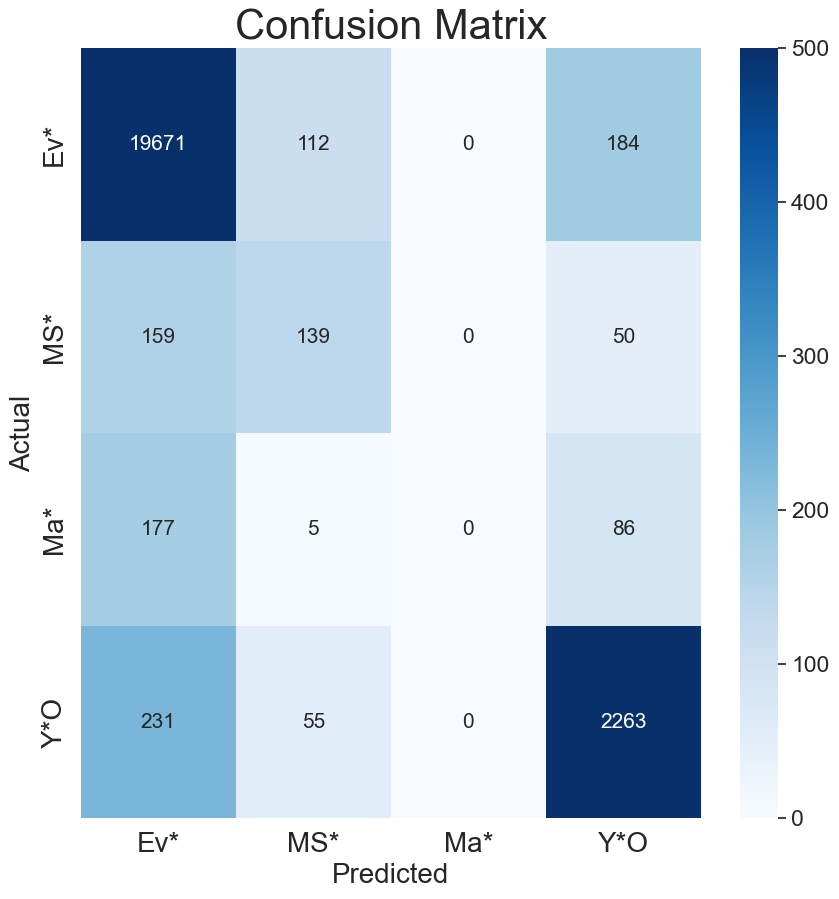

In [10]:
# Load the saved model
#model.load_state_dict(torch.load('star_classifier_y4cat.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(y_batch.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.categories_[0][unique_labels])
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

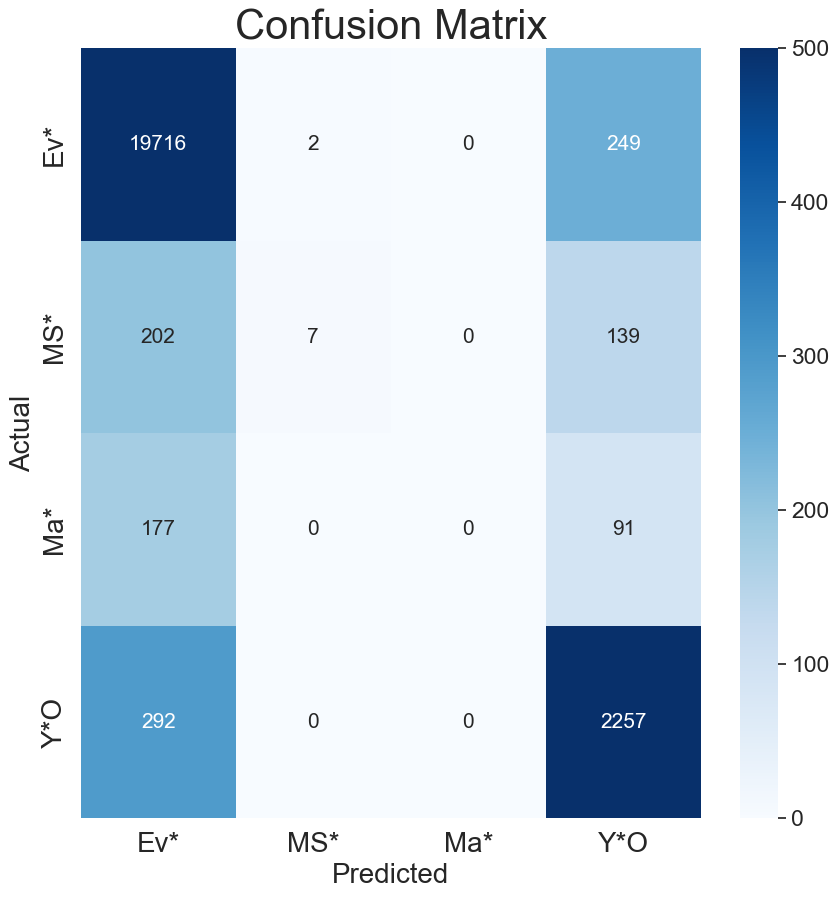

In [7]:
# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0], annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()